In [1]:
import torch
import matplotlib.pyplot as plt

from models.wta_cnp import WTA_CNP
from data.data_generators import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

/home/yigit/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Hyperparameters
batch_size = 32
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 100
num_classes = 4
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 32
num_val_indiv = num_val//num_classes

colors = ['r', 'g', 'b', 'm']

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1]) VX: torch.Size([32, 200, 1]) VY: torch.Size([32, 200, 1])


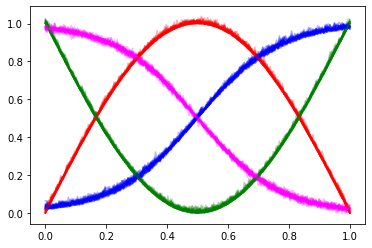

In [3]:
# Generating the data
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

generator_functions = [generate_sin, generate_cos, generate_cx_sigm, generate_reverse_cx_sigm]

for i in range(num_classes):
    noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip
    y[i*num_indiv:(i+1)*num_indiv] = torch.unsqueeze(generator_functions[i](x) + noise, 2)
    noise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - noise_clip
    vy[i*num_val_indiv:(i+1)*num_val_indiv] = torch.unsqueeze(generator_functions[i](vx) + noise, 2)

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

for i in range(num_indiv):
    plt.plot(x[i, :, 0], y[i, :, 0], 'r', alpha=0.3)
    plt.plot(x[i+num_indiv, :, 0], y[i+num_indiv, :, 0], 'g', alpha=0.3)
    plt.plot(x[i+2*num_indiv, :, 0], y[i+2*num_indiv, :, 0], 'b', alpha=0.3)
    plt.plot(x[i+3*num_indiv, :, 0], y[i+3*num_indiv, :, 0], 'magenta', alpha=0.3)
plt.show()

x, y = x.to(device), y.to(device)

In [4]:
def get_batch(x, y, traj_ids):
    n_t = torch.randint(1, n_max_tar, (1,)).item()
    n_o = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    # print("Obs:", obs.shape, "Tar:", tar.shape, "Tar_val:", tar_val.shape)
    return obs, tar, tar_val

In [5]:
def get_validation_batch(vx, vy, o_ids=[0, -1]):
    obs = torch.cat((vx[:, o_ids, :], vy[:, o_ids, :]), dim=-1).to(device)
    tar = vx[:, torch.arange(t_steps)].to(device)
    tar_val= vy[:, torch.arange(t_steps)].to(device)

    return obs, tar, tar_val

In [6]:
model = WTA_CNP(1, 1, 10, 10, [256, 256, 256], 4, [128, 128], 32).to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())
# model

In [9]:
import time

file_name = int(time.time())

epochs = 5000000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
avg_loss = 0

val_per_epoch = 1000
min_val_loss = 1000000

mse_loss = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer.zero_grad()
        obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
        pred, gate = model(obs, tar_x)
        loss = model.loss(pred, gate, tar_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % val_per_epoch == 0:
        o, t, tr = get_validation_batch(vx, vy)

        with torch.no_grad():
            p, g = model(o, t)
            # dec_id = torch.zeros_like(g, device=device)
            dec_id = torch.argmax(g.squeeze(1), dim=-1)
            vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
            val_loss = mse_loss(vp_means, tr).item()

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'New best: {min_val_loss}')
                torch.save(model.state_dict(), f'saved_models/wtacnp_synth_{file_name}.pt')

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
        avg_loss = 0


tensor(0.0687) tensor(0.1011) tensor(0.0911)
tensor(0.0687) tensor(0.1011) tensor(0.0911)
New best: 0.29764387011528015
Epoch: 0, Loss: 0.1301521110534668


2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
3
3
3
3
3
3
3
3


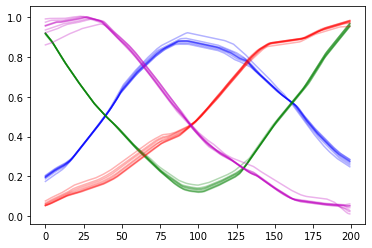

In [10]:
# Testing the best model
# model = WTA_CNP(1, 1, 10, 10, [256, 256, 256], 4, [128, 128], batch_size)
# model.load_state_dict(torch.load(f'saved_models/wtacnp_synth_{file_name}.pt'))
# model.eval()

# o, t, tr = get_validation_batch(vx, vy)

# with torch.no_grad():
#     p, g = model(o, t)

# p, g = p.cpu().numpy(), g.cpu()
# t, tr = t.cpu().numpy(), tr.cpu().numpy()

# for i in range(batch_size):
#     dec_id = torch.argmax(g[i, :, :]).item()
#     print(dec_id)
#     plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.3)

In [12]:
# pytorch_total_params = sum(p.numel() for p in model.parameters())
# print(pytorch_total_params)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(pytorch_total_params)

166662
166662
